In [1]:
# Cell 1: imports and config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats   # for t-test
# display options
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.dpi"] = 100
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

In [3]:
# Cell 2: load
PATH = "data/Unemployment in India.csv"   # put your full CSV here
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]
df.head()

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area
0,Andhra Pradesh,31-05-2019,Monthly,3.65,11999139.0,43.24,Rural
1,Andhra Pradesh,30-06-2019,Monthly,3.05,11755881.0,42.05,Rural
2,Andhra Pradesh,31-07-2019,Monthly,3.75,12086707.0,43.50,Rural
3,Andhra Pradesh,31-08-2019,Monthly,3.32,12285693.0,43.97,Rural
4,Andhra Pradesh,30-09-2019,Monthly,5.17,12256762.0,44.68,Rural


In [5]:
# Cell 2: load
PATH = "data/Unemployment_Rate_upto_11_2020.csv"   # put your full CSV here
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]
df.head()

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Region.1,longitude,latitude
0,Andhra Pradesh,31-01-2020,M,5.48,16635535,41.02,South,15.9129,79.74
1,Andhra Pradesh,29-02-2020,M,5.83,16545652,40.90,South,15.9129,79.74
2,Andhra Pradesh,31-03-2020,M,5.79,15881197,39.18,South,15.9129,79.74
3,Andhra Pradesh,30-04-2020,M,20.51,11336911,33.10,South,15.9129,79.74
4,Andhra Pradesh,31-05-2020,M,17.43,12988845,36.46,South,15.9129,79.74


In [7]:
# Cell 3: standardize columns (edit mapping if your CSV has different names)
rename_map = {
    "Region":"state",
    "Region ":"state",
    "Estimated Unemployment Rate (%)":"unemp_rate",
    "Estimated Unemployment Rate":"unemp_rate",
    "Estimated Employed":"employed",
    "Estimated Labour Participation Rate (%)":"lpr",
    "Date":"Date",
    "Frequency":"Frequency",
    "Area":"area",
    "Zone":"zone",
    "longitude":"longitude",
    "latitude":"latitude"
}
# apply only existing keys
rename_map = {k:v for k,v in rename_map.items() if k in df.columns}
df = df.rename(columns=rename_map)
df.columns


Index(['state', 'Date', 'Frequency', 'unemp_rate', 'employed', 'lpr',
       'Region.1', 'longitude', 'latitude'],
      dtype='object')

In [9]:
# Cell 4: cleaning basic
# strip whitespace in text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# normalize frequency values
if "Frequency" in df.columns:
    df["Frequency"] = df["Frequency"].replace({"M":"Monthly","m":"Monthly","monthly":"Monthly"})

# numeric coercion
for c in ["unemp_rate","employed","lpr","longitude","latitude"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


In [11]:
# Cell 5: date parsing
# try day-month-year first (common format in your sample)
df["Date_parsed"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# fallback if many NaT
if df["Date_parsed"].isna().mean() > 0.25:
    df["Date_parsed"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)

# replace Date with parsed column
df["Date"] = df["Date_parsed"]
df = df.drop(columns=["Date_parsed"])
# check
print("Date null %:", df["Date"].isna().mean())
df[["Date"]].head()


Date null %: 0.0


,Date
0,2020-01-31
1,2020-02-29
2,2020-03-31
3,2020-04-30
4,2020-05-31


In [13]:
# Cell 6: drop rows without Date or unemp_rate (these are essential)
before = len(df)
df = df.dropna(subset=["Date"])
if "unemp_rate" in df.columns:
    df = df.dropna(subset=["unemp_rate"])
after = len(df)
print("Dropped rows:", before - after)

# remove exact duplicates
df = df.drop_duplicates()
print("Rows after dedupe:", len(df))


Dropped rows: 0
Rows after dedupe: 267


In [15]:
# Cell 7: features
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["month_name"] = df["Date"].dt.month_name()

# define COVID period flags (customize dates if needed)
covid_start = pd.Timestamp(2020,3,1)
covid_end = pd.Timestamp(2021,12,31)
df["period"] = np.where(df["Date"] < covid_start, "pre_covid",
                 np.where(df["Date"] <= covid_end, "covid", "post_covid"))

# rolling averages per state
if "state" in df.columns:
    df = df.sort_values(["state","Date"])
    df["unemp_roll3"] = df.groupby("state")["unemp_rate"].transform(lambda s: s.rolling(3, min_periods=1).mean())
else:
    df = df.sort_values("Date")
    df["unemp_roll3"] = df["unemp_rate"].rolling(3, min_periods=1).mean()

df.head()


,state,Date,Frequency,unemp_rate,employed,lpr,Region.1,longitude,latitude,year,month,month_name,period,unemp_roll3
0,Andhra Pradesh,2020-01-31,Monthly,5.48,16635535,41.02,South,15.9129,79.74,2020,1,January,pre_covid,5.480000
1,Andhra Pradesh,2020-02-29,Monthly,5.83,16545652,40.90,South,15.9129,79.74,2020,2,February,pre_covid,5.655000
2,Andhra Pradesh,2020-03-31,Monthly,5.79,15881197,39.18,South,15.9129,79.74,2020,3,March,covid,5.700000
3,Andhra Pradesh,2020-04-30,Monthly,20.51,11336911,33.10,South,15.9129,79.74,2020,4,April,covid,10.710000
4,Andhra Pradesh,2020-05-31,Monthly,17.43,12988845,36.46,South,15.9129,79.74,2020,5,May,covid,14.576667


In [17]:
# Cell 8: descriptive stats and counts
print("Rows:", len(df))
if "state" in df.columns:
    print("States:", df["state"].nunique())
print("Date range:", df["Date"].min(), "to", df["Date"].max())
display(df["unemp_rate"].describe())
# state-wise summary
if "state" in df.columns:
    state_summary = df.groupby("state")["unemp_rate"].agg(["mean","median","std","count"]).sort_values("mean", ascending=False)
    display(state_summary.head(20))


Rows: 267
States: 27
Date range: 2020-01-31 00:00:00 to 2020-10-31 00:00:00


count    267.000000
mean      12.236929
std       10.803283
min        0.500000
25%        4.845000
50%        9.650000
75%       16.755000
max       75.850000
Name: unemp_rate, dtype: float64

,mean,median,std,count
state,,,,
Haryana,27.477000,26.235,6.819379,10
Tripura,25.055000,24.815,8.656338,10
Jharkhand,19.539000,11.205,18.342961,10
Bihar,19.471000,13.115,14.348846,10
Delhi,18.414000,16.860,9.477608,10
Puducherry,17.942000,5.615,26.593279,10
Jammu & Kashmir,16.477778,16.170,3.681293,9
Himachal Pradesh,16.065000,16.310,6.806424,10
Rajasthan,15.868000,15.545,3.610989,10


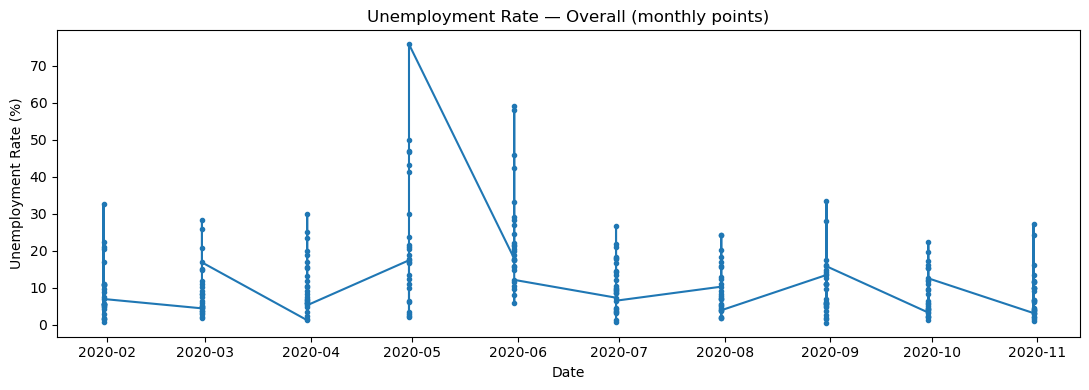

In [19]:
# Cell 9: national trend
d = df.sort_values("Date")
plt.figure(figsize=(11,4))
plt.plot(d["Date"], d["unemp_rate"], marker=".", linestyle="-")
plt.title("Unemployment Rate — Overall (monthly points)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/trend_overall.png")
plt.show()


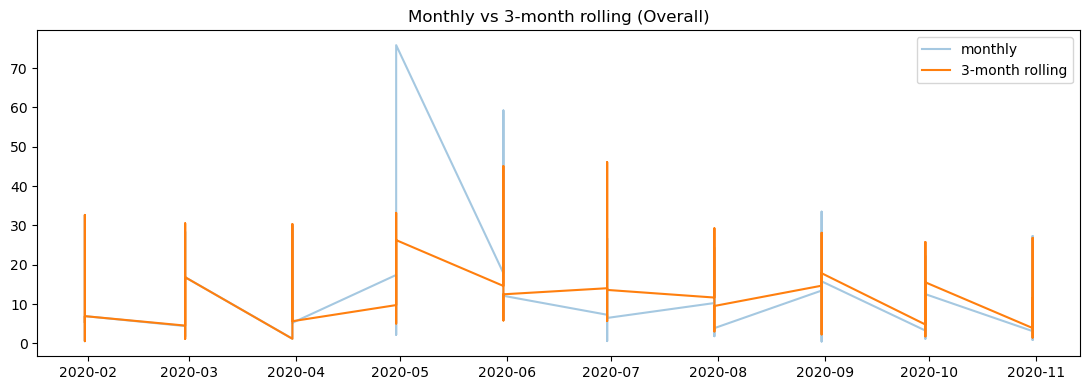

In [21]:
# Cell 10: trend + rolling
plt.figure(figsize=(11,4))
plt.plot(d["Date"], d["unemp_rate"], alpha=0.4, label="monthly")
plt.plot(d["Date"], d["unemp_roll3"], label="3-month rolling")
plt.legend()
plt.title("Monthly vs 3-month rolling (Overall)")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/trend_overall_rolling.png")
plt.show()


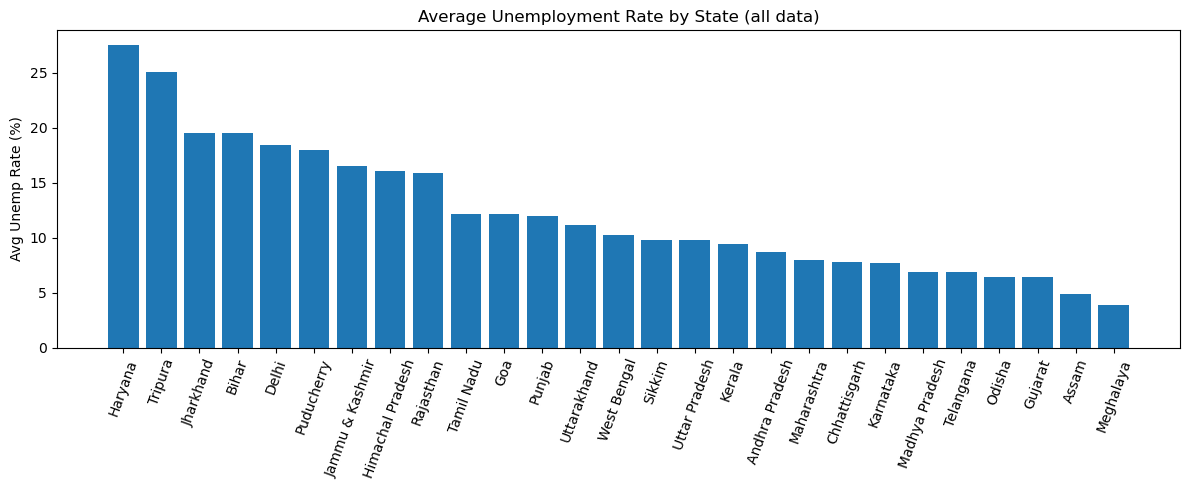

In [23]:
# Cell 11: average by state
if "state" in df.columns:
    avg_state = df.groupby("state", as_index=False)["unemp_rate"].mean().sort_values("unemp_rate", ascending=False)
    plt.figure(figsize=(12,5))
    plt.bar(avg_state["state"], avg_state["unemp_rate"])
    plt.xticks(rotation=70)
    plt.title("Average Unemployment Rate by State (all data)")
    plt.ylabel("Avg Unemp Rate (%)")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/state_avg.png")
    plt.show()


In [29]:
# Cell 12: per-state trend images (useful for report)
if "state" in df.columns:
    for st, grp in df.groupby("state"):
        grp = grp.sort_values("Date")
        if len(grp) < 3: 
            continue
        plt.figure(figsize=(9,3))
        plt.plot(grp["Date"], grp["unemp_rate"], marker="o")
        plt.plot(grp["Date"], grp["unemp_roll3"], linestyle="--")
        plt.title(f"Trend — {st}")
        plt.tight_layout()
        safe = st.lower().replace(" ", "_")
        plt.savefig(f"{OUTDIR}/state_trend_{safe}.png")
        plt.close()


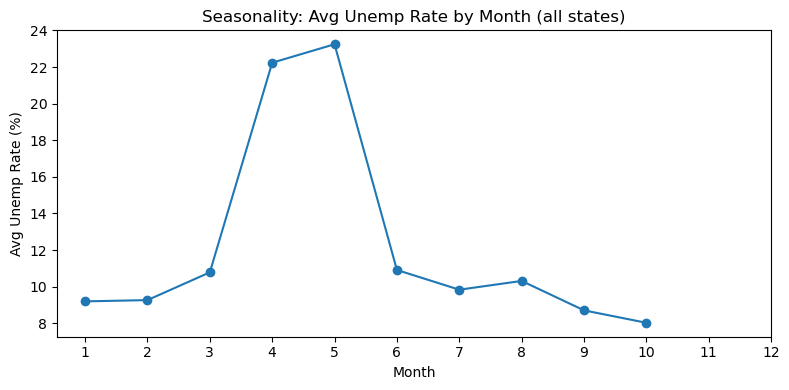

NameError: name 'calendar' is not defined

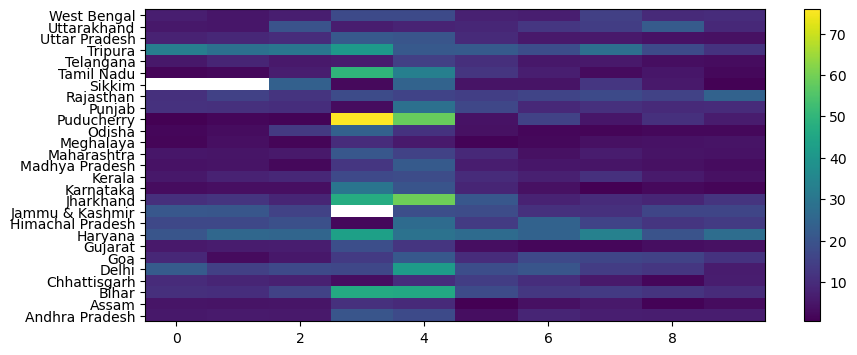

In [30]:
# Cell 13: seasonality: month average
monthly = df.groupby("month", as_index=False)["unemp_rate"].mean().sort_values("month")
plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["unemp_rate"], marker="o")
plt.xticks(range(1,13))
plt.title("Seasonality: Avg Unemp Rate by Month (all states)")
plt.xlabel("Month")
plt.ylabel("Avg Unemp Rate (%)")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/seasonality_monthly.png")
plt.show()

# heatmap (month vs state) using pivot + imshow
if "state" in df.columns:
    piv = df.pivot_table(values="unemp_rate", index="state", columns="month", aggfunc="mean")
    plt.figure(figsize=(10, max(4, 0.15*len(piv))))
    plt.imshow(piv, aspect="auto", origin="lower")
    plt.colorbar()
    plt.yticks(ticks=np.arange(len(piv.index)), labels=piv.index)
    plt.xticks(ticks=np.arange(12), labels=[calendar.month_abbr[i+1] for i in range(12)])
    plt.title("Heatmap: Avg Unemp Rate (state vs month)")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/heatmap_state_month.png")
    plt.show()


Pre-COVID mean: 9.231346153846154 COVID mean: 12.963860465116278


C:\Users\sakshi dewangan\AppData\Local\Temp\ipykernel_20080\1573576309.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


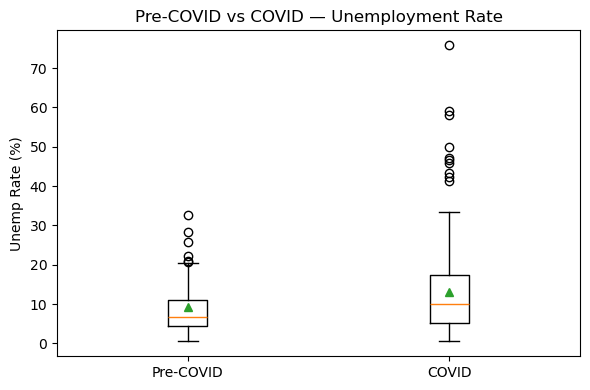

,state,pre_mean,covid_mean,delta
0,Puducherry,1.170,22.13500,20.96500
1,Tamil Nadu,1.830,14.77625,12.94625
2,Bihar,10.450,21.72625,11.27625
3,Jharkhand,11.230,21.61625,10.38625
4,Goa,5.850,13.74625,7.89625
5,Uttarakhand,5.240,12.63500,7.39500
6,Karnataka,3.235,8.77625,5.54125
7,Haryana,23.055,28.58250,5.52750
8,West Bengal,5.930,11.25750,5.32750
9,Odisha,2.510,7.45000,4.94000


In [32]:
# Cell 14: COVID impact
pre = df[df["period"]=="pre_covid"]["unemp_rate"].dropna()
cov = df[df["period"]=="covid"]["unemp_rate"].dropna()
print("Pre-COVID mean:", pre.mean(), "COVID mean:", cov.mean())

# boxplot (requires at least two groups)
groups = [pre, cov]
labels = ["Pre-COVID", "COVID"]
plt.figure(figsize=(6,4))
plt.boxplot(groups, labels=labels, showmeans=True)
plt.title("Pre-COVID vs COVID — Unemployment Rate")
plt.ylabel("Unemp Rate (%)")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/covid_boxplot.png")
plt.show()

# per-state means and delta
if "state" in df.columns:
    pre_state = df[df["period"]=="pre_covid"].groupby("state")["unemp_rate"].mean()
    cov_state = df[df["period"]=="covid"].groupby("state")["unemp_rate"].mean()
    delta = pd.concat([pre_state, cov_state], axis=1).rename(columns={"unemp_rate":"pre_mean"})
    delta.columns = ["pre_mean","covid_mean"]
    delta["delta"] = delta["covid_mean"] - delta["pre_mean"]
    delta = delta.sort_values("delta", ascending=False).reset_index()
    display(delta.head(15))


In [34]:
# Cell 15: t-test pre vs covid (national)
if len(pre) >= 5 and len(cov) >= 5:
    tstat, pval = stats.ttest_ind(pre, cov, equal_var=False, nan_policy="omit")
    print("t-stat:", tstat, "p-value:", pval)
else:
    print("Not enough observations for t-test at national level.")
# For each state: quick t-test where enough data
if "state" in df.columns:
    tt_results = []
    for st, grp in df.groupby("state"):
        pre_s = grp[grp["period"]=="pre_covid"]["unemp_rate"]
        cov_s = grp[grp["period"]=="covid"]["unemp_rate"]
        if len(pre_s)>=3 and len(cov_s)>=3:
            t,p = stats.ttest_ind(pre_s, cov_s, equal_var=False, nan_policy="omit")
            tt_results.append((st, len(pre_s), len(cov_s), round(pre_s.mean(),2), round(cov_s.mean(),2), round(p,4)))
    tt_df = pd.DataFrame(tt_results, columns=["state","n_pre","n_cov","mean_pre","mean_cov","p_val"]).sort_values("p_val")
    display(tt_df.head(20))


t-stat: -2.910510890558953 p-value: 0.004317417148146143


,state,n_pre,n_cov,mean_pre,mean_cov,p_val


,state,Date,unemp_rate
172,Puducherry,2020-04-30,75.85
103,Jharkhand,2020-05-31,59.23
173,Puducherry,2020-05-31,58.19
210,Tamil Nadu,2020-04-30,49.83
102,Jharkhand,2020-04-30,47.09
23,Bihar,2020-04-30,46.64
24,Bihar,2020-05-31,45.96
73,Haryana,2020-04-30,43.22
44,Delhi,2020-05-31,42.27
230,Tripura,2020-04-30,41.23


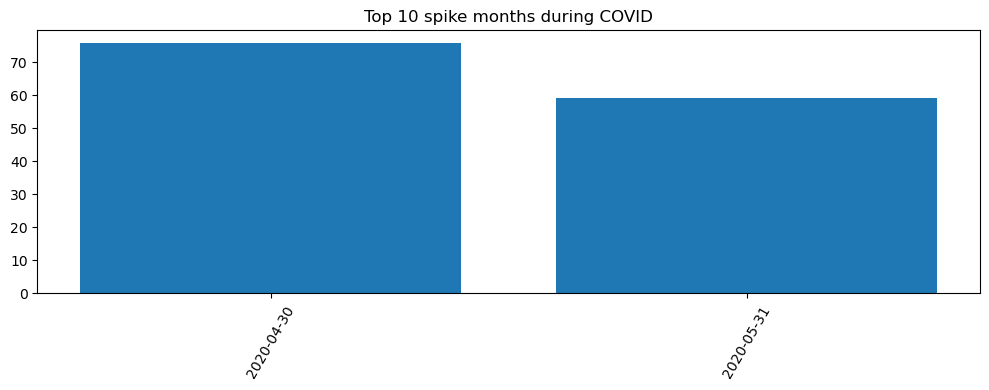

In [36]:
# Cell 16: top spikes
spikes = df[df["period"]=="covid"].nlargest(10, "unemp_rate")[["state","Date","unemp_rate"]]
display(spikes)
# bar plot
plt.figure(figsize=(10,4))
plt.bar(spikes["Date"].astype(str), spikes["unemp_rate"])
plt.xticks(rotation=60)
plt.title("Top 10 spike months during COVID")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/top_spikes.png")
plt.show()


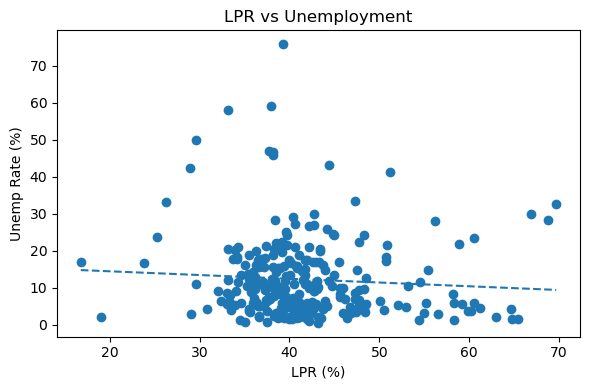

In [38]:
# Cell 17: relationship tests
if "lpr" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["lpr"], df["unemp_rate"])
    z = np.polyfit(df["lpr"].dropna(), df["unemp_rate"].dropna(), 1)
    p = np.poly1d(z)
    xvals = np.linspace(df["lpr"].min(), df["lpr"].max(), 100)
    plt.plot(xvals, p(xvals), linestyle="--")
    plt.title("LPR vs Unemployment")
    plt.xlabel("LPR (%)")
    plt.ylabel("Unemp Rate (%)")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/scatter_lpr_unemp.png")
    plt.show()


In [44]:
# Cell 19: save cleaned and key tables
df.to_csv("data/unemployment_cleaned.csv", index=False)
if "state" in df.columns:
    avg_state.to_csv(f"{OUTDIR}/state_avg_table.csv", index=False)
    delta.to_csv(f"{OUTDIR}/covid_state_delta.csv", index=False)
print("Saved cleaned dataset and tables.")



Saved cleaned dataset and tables.
